# Dimensionality reduction on trial features

In [16]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [20]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode

# from tslearn.barycenters import dtw_barycenter_averaging
# from tslearn.preprocessing import TimeSeriesResampler
# from tslearn.metrics import dtw_path

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [21]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [22]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per session

In [23]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

In [ ]:
# use_key = 'feedback' # session trial_typefilter
# use_order = ['correct', 'incorrect']
# # use_order = ['0.0', '0.0625', '0.125', '0.25', '1.0']
# # use_order = ['0.5', '0.2', '0.8']
# unique_numeric_labels = np.arange(0, len(use_order), 1)
# map_to_use = dict(zip(use_order, unique_numeric_labels))

# # Apply map
# unique_trial_types = trial_clusters[use_key].unique()
# # trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
# trial_clusters['numeric_trial_code'] = trial_clusters[use_key].map(map_to_use)

In [ ]:
# # Load trial clsuters
# results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
# parts_filename = str(results_path + 'cluster_per_session_part03-21-2025')
# parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

# parts_clusters['session'] = parts_clusters['sample'].str.split().str[:1].str.join('')
# parts_clusters['trial_id'] = parts_clusters['sample'].str.split().str[1:2].str.join('')

# trial_clusters = trial_clusters.merge(parts_clusters[['session', 'part_cluster']], on='session')

## Get sequence of trial modes

In [24]:
plot = False
target_length = 3

all_sequences = pd.DataFrame(columns=['session', 'mouse_name', 'trial_type', 'cluster', 'bin'])
for s, session in enumerate(trial_clusters['session'].unique()):

    # Get session data and order trials
    session_data = trial_clusters.loc[trial_clusters['session']==session]
    session_data = session_data[['session', 'mouse_name', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
    session_data['trial_id'] = session_data['trial_id'].astype(float)
    session_data = session_data.sort_values(by=['trial_id'])

    # Bin 
    n_trials = len(session_data)
    # Assign bin index: split into 10 parts
    bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
    session_data['bin'] = bin_indices
      
    all_sequences = pd.concat([all_sequences, session_data[['session', 'mouse_name',
                                                            'trial_type', 'cluster', 'bin']]], ignore_index=True)


In [25]:
fractions = all_sequences.groupby(['session', 'mouse_name',
                                   'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
fractions

,session,mouse_name,bin,cluster,fraction
5,03063955-2523-47bd-ae57-f7489dd40f15,SWC_038,0,0,0.097561
25,032452e9-1886-449d-9c13-0f192572e19f,SWC_053,0,0,0.074074
44,034e726f-b35f-41e0-8d6c-a22cc32391fb,CSHL045,0,0,0.128205
65,03d9a098-07bf-4765-88b7-85f8d8f620cc,UCLA014,0,0,0.089947
81,0802ced5-33a3-405e-8336-b65ebc5cb07c,ZFM-02373,0,0,0.269504
...,...,...,...,...,...
4108,fb70ebf7-8175-42b0-9b7a-7c6e8612226e,CSHL058,2,6,0.441315
4128,fc14c0d6-51cf-48ba-b326-56ed5a9420c3,SWC_052,2,6,0.286550
4153,fc43390d-457e-463a-9fd4-b94a0a8b48f5,NYU-47,2,6,0.094241
4171,ff48aa1d-ef30-4903-ac34-8c41b738c1b9,CSH_ZAD_025,2,6,0.203175


In [26]:
design_df = fractions.pivot(index=['mouse_name', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)
var_names = design_df.keys()[2:]
final_matrix = design_df[var_names]

([<matplotlib.axis.XTick at 0x7378362bcc70>], [Text(0, 0, '0')])

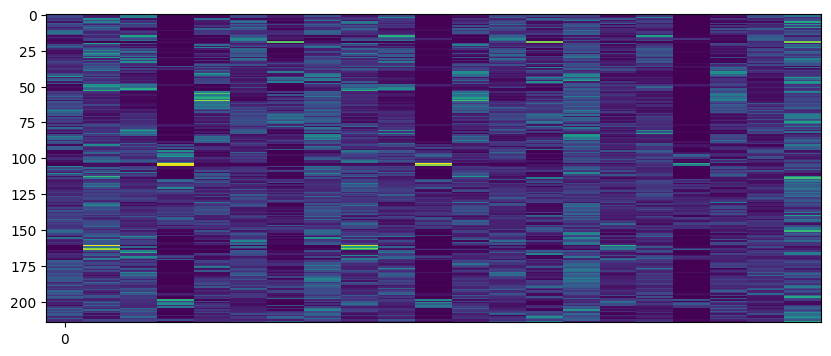

In [27]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

## Prepare design matrix

In [28]:
ori_X = final_matrix.copy()

print(np.shape(ori_X))

(215, 21)


## Reduce dimensionality with PCA

In [29]:
n_components = 10
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(ori_X)


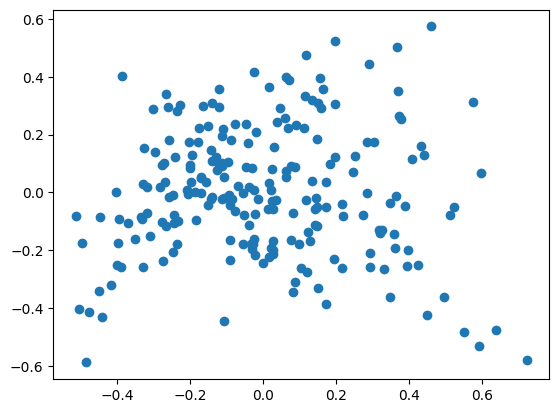

In [30]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])

In [31]:
import plotly.express as px

components = X_pca[:, :3]
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components
)
fig.update_traces(diagonal_visible=False)
fig.show()

Text(0.5, 1.0, 'Explained Variance by PCA')

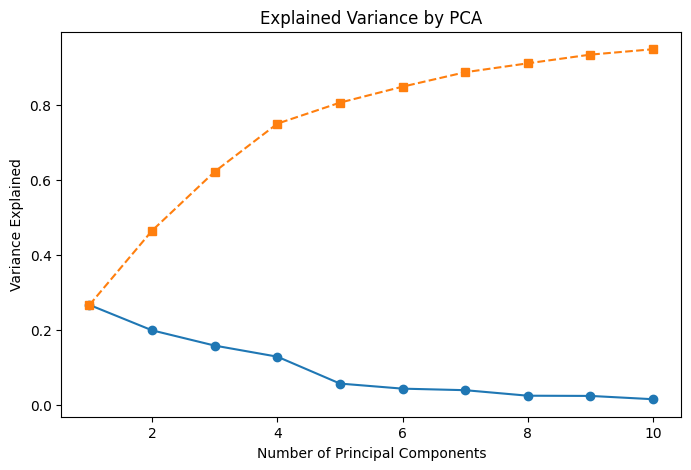

In [32]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")


## UMAP assessment

In [305]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

embedding = reducer.fit_transform(ori_X)
# embedding = reducer.fit_transform(X_pca)
embedding.shape

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(215, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Sessions')

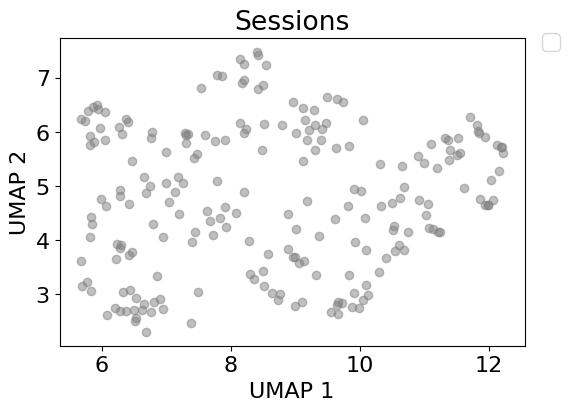

In [306]:
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 16})

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.5,
    c='grey'  # Choose a colormap
)   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title('Sessions')

# Save the figure as an SVG file
# plt.savefig(file_path+'UMAP_grey', format="svg")

In [ ]:
from kneed import KneeLocator
# Assuming `X` is your data
inertia_values = []
K = range(1, 60)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(embedding)[0]*0.8)
    X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.title(epoch_to_analyse)
# Save the figure as an SVG file
save_path = prefix + 'representation_learning_variability/Exported figures/COSYNE/'
# plt.savefig(save_path+'inertia_values_trial_clusters.svg', format="svg")
plt.show()

ModuleNotFoundError: No module named 'kneed'

## Test GMM with different components

In [297]:
repeats = 1
components = np.array([1, 2, 3, 4, 5, 6, 7])
components = np.arange(1, 30, 1)
# components = np.array([3, 6, 9])


In [302]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    embeding = reducer.fit_transform(ori_X)
    embeding.shape
    
    # embedding = X_pca[:, :2]
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(embeding, components)


<ErrorbarContainer object of 3 artists>

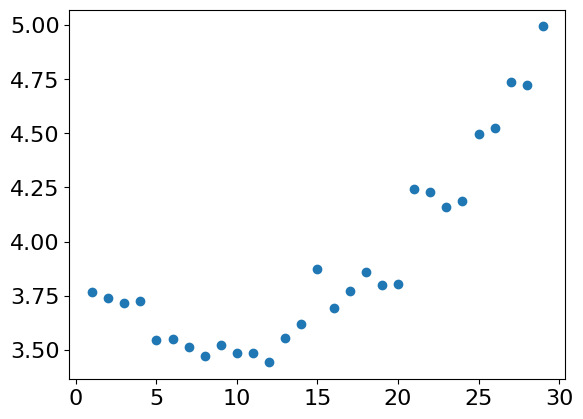

In [303]:
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')


In [ ]:

kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')

plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')


NameError: name 'KneeLocator' is not defined

## K-means clustering of data

In [317]:
optimal_k = 5

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



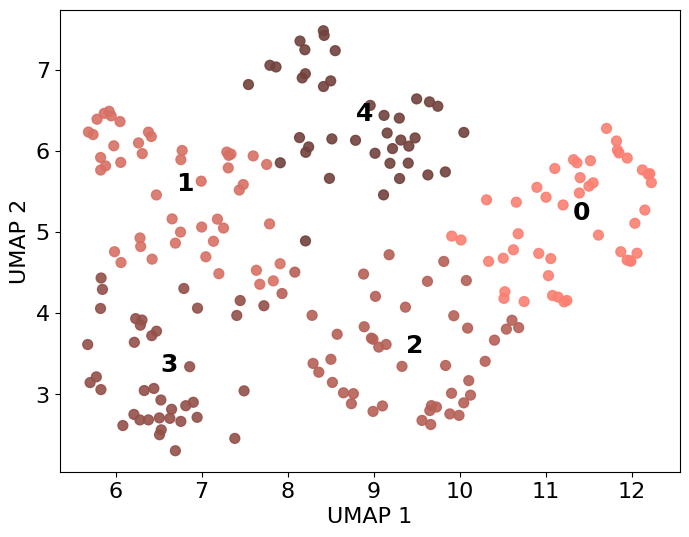

In [318]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
# data_2d = X_pca
kmeans_trials = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans_trials.fit(data_2d)

y_kmeans_trials = kmeans_trials.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))
# Plot each cluster with a different color
palette = sns.color_palette("Set2", 7)  # List of 6 colors
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
# Map the cluster labels to colors
colors = [palette[i] for i in y_kmeans_trials]
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], s=50, alpha=0.9, c=colors) # sns.color_palette("Set2", as_cmap=True) , cmap='Set2' c=y_kmeans_trials, 

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=1, fontsize=18, weight='bold')


# plt.title(epoch_to_analyse + " clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.title(epoch_to_analyse)

# Save the figure as an SVG file
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/'
# plt.savefig(save_path+'trial_clusters_umap.svg', format="svg")
plt.show()

In [319]:
design_df['session_cluster'] = y_kmeans_trials 

# Save for further mouse clustering

In [25]:
file_to_save = merged_df.copy()
filename = "cluster_per_trial_no_timing"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '2.4_trial_epoch_seq_clustering.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Vizualize results

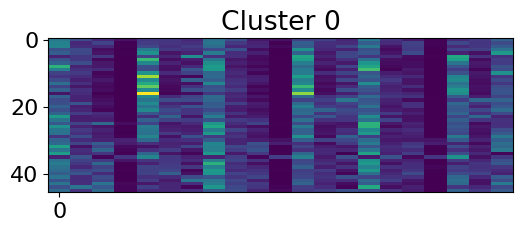

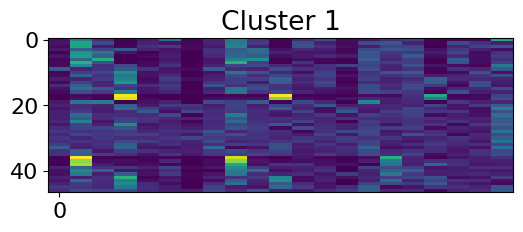

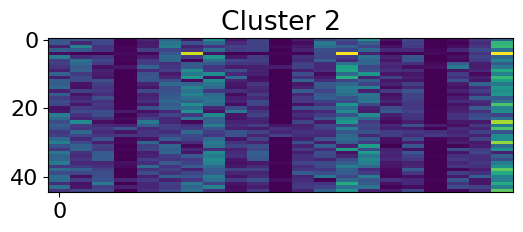

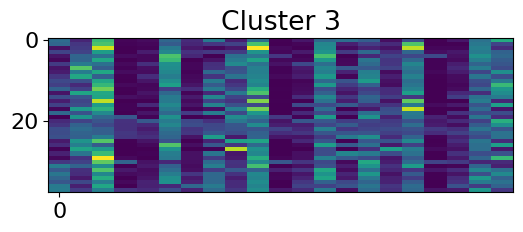

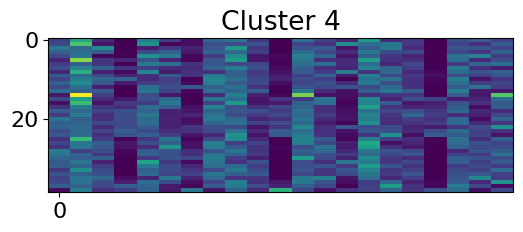

In [320]:
for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    indices = np.where(y_kmeans_trials==c)[0]
    data = np.array(final_matrix)[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_97341/4276721136.py:4: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_97341/4276721136.py:6: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_97341/4276721136.py:4: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/var/folders/nt/d2j3zp

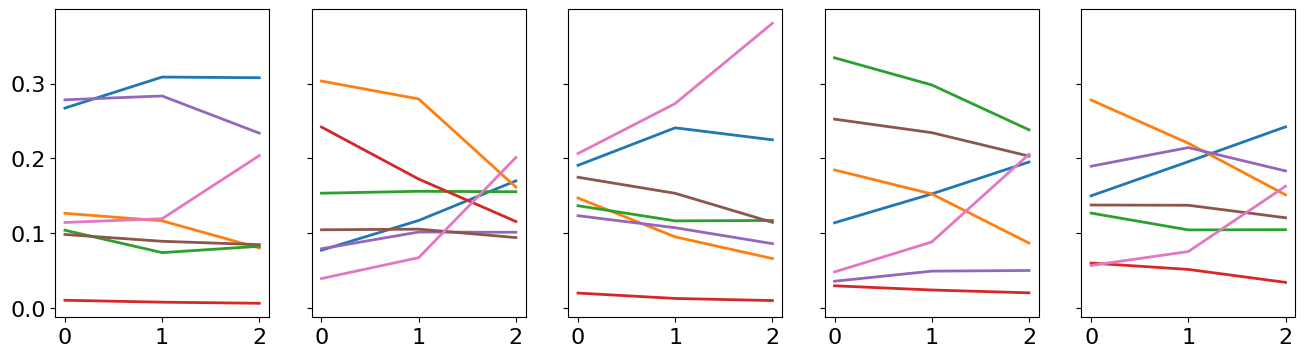

In [321]:
fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=True, figsize=(16, 4))

for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    new_df = final_matrix.stack(0).unstack()
    use_data = new_df.iloc[np.where(y_kmeans_trials==c)]
    sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    axs[c].plot(np.nanmean(use_data[0], axis=0), linewidth=2, label='Trial mode 0')
    axs[c].plot(np.nanmean(use_data[1], axis=0), linewidth=2, label='Trial mode 1')
    axs[c].plot(np.nanmean(use_data[2], axis=0), linewidth=2, label='Trial mode 2')
    axs[c].plot(np.nanmean(use_data[3], axis=0), linewidth=2, label='Trial mode 3')
    axs[c].plot(np.nanmean(use_data[4], axis=0), linewidth=2, label='Trial mode 4')
    axs[c].plot(np.nanmean(use_data[5], axis=0), linewidth=2, label='Trial mode 5')
    axs[c].plot(np.nanmean(use_data[6], axis=0), linewidth=2, label='Trial mode 6')

In [322]:
new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']]

In [323]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_97341/1454291506.py:3: DtypeWarning:

Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.



In [324]:
df = new_df.merge(learning_times, on='mouse_name')

In [325]:
data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

a = df[['mouse_name', 'training_time']].merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

Text(0, 0.5, 'Number of mice')

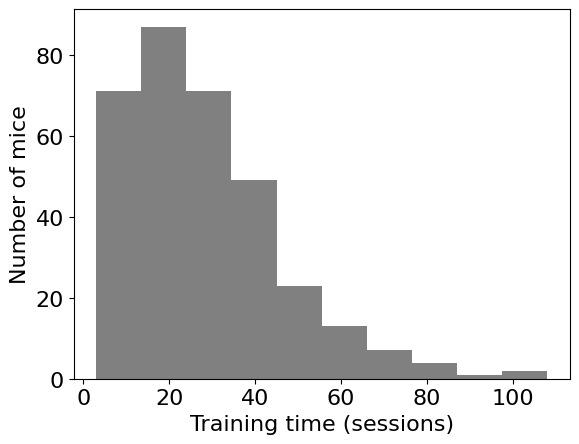

In [326]:
plt.rcParams.update({'font.size': 16})
plt.hist(full_learning['training_time'], color='grey')
plt.xlabel('Training time (sessions)')
plt.ylabel('Number of mice')

                       sum_sq     df         F    PR(>F)
session_cluster    151.103020    1.0  0.815128  0.367648
Residual         38743.048639  209.0       NaN       NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -1.2897 0.9914  -9.1532  6.5739  False
     0      2   0.2373    1.0  -7.8011  8.2758  False
     0      3  -1.9677 0.9661 -10.2693  6.3339  False
     0      4   3.3852 0.7905  -4.8591 11.6295  False
     1      2    1.527  0.984  -6.3837  9.4376  False
     1      3  -0.6781 0.9994   -8.856  7.4998  False
     1      4   4.6748  0.509  -3.4449 12.7946  False
     2      3   -2.205   0.95 -10.5512  6.1412  False
     2      4   3.1479  0.834  -5.1413 11.4371  False
     3      4   5.3529 0.4215  -3.1917 13.8976  False
-----------------------------------------------------


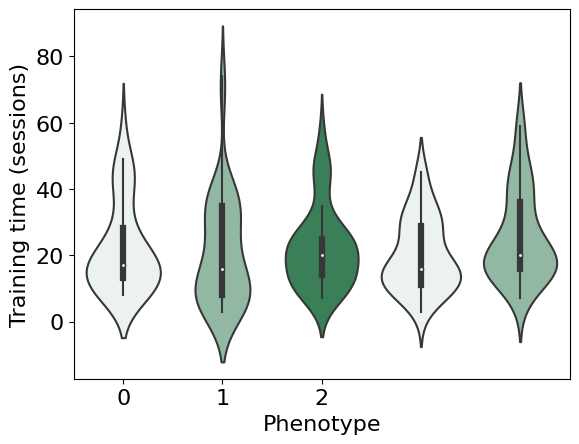

P-value for KW: 0.407
     0         1    2    3         4
0  1.0  1.000000  1.0  1.0  1.000000
1  1.0  1.000000  1.0  1.0  0.234792
2  1.0  1.000000  1.0  1.0  1.000000
3  1.0  1.000000  1.0  1.0  1.000000
4  1.0  0.234792  1.0  1.0  1.000000


In [327]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['session_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 80])
plt.xlabel('Phenotype')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.show()

group_1 = df.loc[df['session_cluster']==0, var]
group_2 = df.loc[df['session_cluster']==1, var]
group_3 = df.loc[df['session_cluster']==2, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)